## XGBoost Solar Generation Model — 2024 Only

This notebook builds an XGBoost regression model to predict daily solar generation using historical weather and calendar features. The goal is to evaluate whether XGBoost improves on the baseline regression model using only 2024 data.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


### Load and View Data

In [3]:
# Load Cleaned Data and view head
df = pd.read_csv("../../Cleaned Data/Cleaned_National_Irish_Weather_Solar_2024.csv")

df.head()

,date,rain,maxtp,mintp,cbl,glorad,solargen
0,1/01/2024,11.93,10.57,3.03,981.90,64.44,471.02
1,2/01/2024,5.77,10.22,6.53,973.32,125.44,601.80
2,3/01/2024,2.10,9.21,5.46,981.98,210.22,1286.11
3,4/01/2024,1.18,8.17,2.52,991.51,309.00,2788.48
4,5/01/2024,0.36,8.18,2.28,1001.11,314.89,2966.48


### Parse Dates and Add Seasonal Features

In [ ]:
# Convert to datetime and extract useful calendar features
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df['month'] = df['date'].dt.month
df['dayofyear'] = df['date'].dt.dayofyear

### Select Features and Target

In [ ]:
# Feature selection
features = ['glorad', 'rain', 'maxtp', 'mintp', 'month', 'dayofyear']
X = df[features]
y = df['solargen']

### Train/Test Split

In [117]:
# Random 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Fit XGBoost Model (Baseline)

In [118]:
# Updated paramters after grid search
model = xgb.XGBRegressor(
    learning_rate=0.05,
    max_depth=3,
    n_estimators=85,
    reg_alpha=0,
    reg_lambda=0.5,
    random_state=42
)

model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### Evaluate Model Performance

In [119]:
# Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Train metrics
r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)

print(f"Train: R²: {r2_train:.3f} | RMSE: {rmse_train:.2f} | MAE: {mae_train:.2f}")

# Test metrics
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"Test : R²: {r2_test:.3f} | RMSE: {rmse_test:.2f} | MAE: {mae_test:.2f}")


Train: R²: 0.951 | RMSE: 1198.80 | MAE: 902.60
Test : R²: 0.849 | RMSE: 2051.67 | MAE: 1410.78


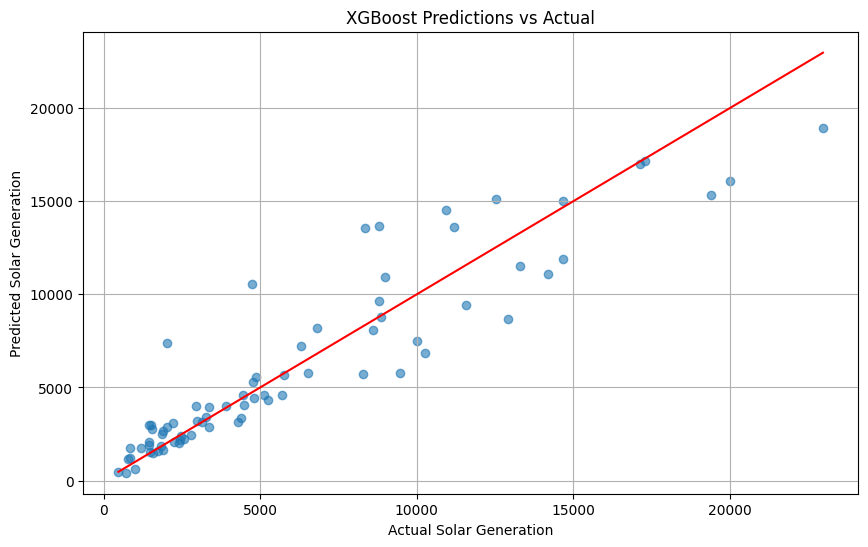

In [18]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.xlabel('Actual Solar Generation')
plt.ylabel('Predicted Solar Generation')
plt.title('XGBoost Predictions vs Actual')
plt.grid(True)
plt.show()


### GridSearch for XGBoost Tuning

In [11]:
from sklearn.model_selection import GridSearchCV

# Define basic parameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'reg_lambda': [0.5, 1, 2],
    'reg_alpha': [0, 0.5, 1]
}

# Set up the regressor
xgb_reg = xgb.XGBRegressor(random_state=42)

# Set up GridSearch
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Run Grid Search
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0.5}


### Plot Grid Search Heatmap

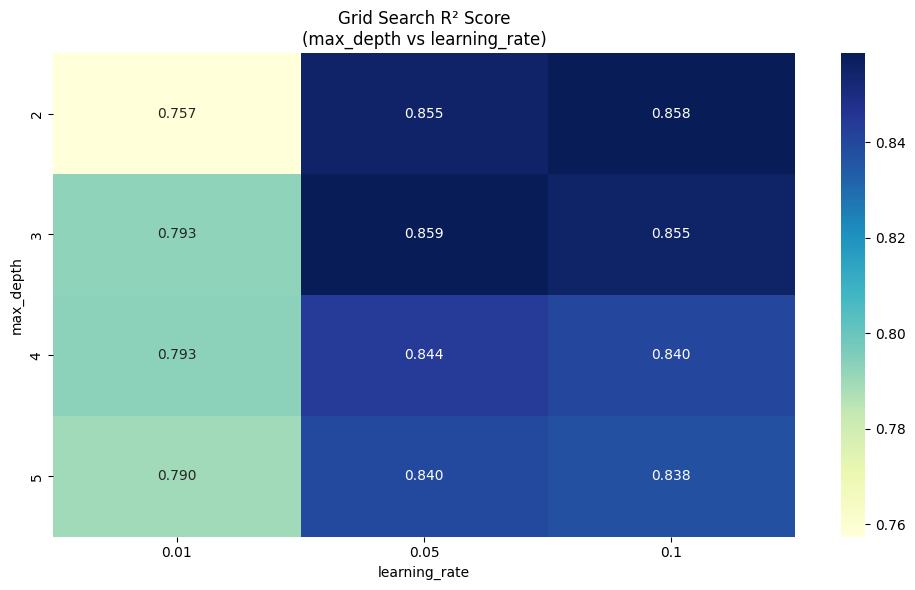

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert GridSearchCV results to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Pivot table: rows = max_depth, cols = learning_rate, values = mean_test_score
heatmap_data = results_df.pivot_table(
    index='param_max_depth',
    columns='param_learning_rate',
    values='mean_test_score'
)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Grid Search R² Score\n(max_depth vs learning_rate)")
plt.xlabel("learning_rate")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()



### Learning Curves: Train vs Test RMSE


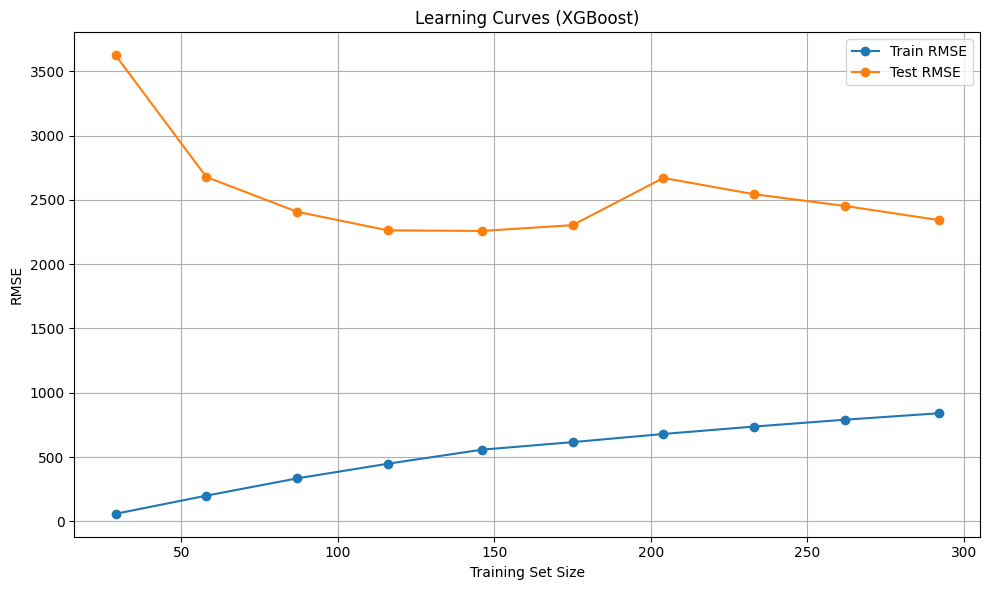

In [19]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


# Use RMSE scorer
def rmse_score(estimator, X, y):
    y_pred = estimator.predict(X)
    return -np.sqrt(mean_squared_error(y, y_pred))

# Set up learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model,               # Your best XGBoost model
    X, y,                # Full dataset
    cv=5,                # 5-fold cross-validation
    scoring=rmse_score,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

# Compute mean RMSE
train_rmse = -np.mean(train_scores, axis=1)
test_rmse = -np.mean(test_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse, label='Train RMSE', marker='o')
plt.plot(train_sizes, test_rmse, label='Test RMSE', marker='o')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curves (XGBoost)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
